(page:how-to-plotting)=
# Plotting
This page contains a few ideas for plotting ApRES data using xApRES, starting with simple implementations of xarray plotting functions and moving on to more complex examples. 

In [1]:
import sys
sys.path.append("../../../xapres") 
import xapres as xa
data = xa.load.load_zarr('gs://ldeo-glaciology/apres/thwaites/continuous/ApRES_LTG/zarr/full.zarr') 
data

<xarray.Dataset> Size: 18GB
Dimensions:          (attenuator_setting_pair: 1, time: 351, chirp_time: 40001,
                      chirp_num: 100, profile_range: 11889)
Coordinates:
    AFGain           (attenuator_setting_pair) int64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    attenuator       (attenuator_setting_pair) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    burst_number     (time) int64 3kB dask.array<chunksize=(351,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
  * chirp_time       (chirp_time) timedelta64[ns] 320kB 00:00:00 ... 00:00:01
    filename         (time) <U90 126kB dask.array<chunksize=(351,), meta=np.ndarray>
    orientation      (time) <U7 10kB dask.array<chunksize=(351,), meta=np.ndarray>
  * profile_range    (profile_range) float64 95kB 0.0 0.2103 ... 2.5e+03 2.5e+03
  * time             (time) datetime64[ns] 3kB 2023-01-16T00:52:00 ... 2023-1...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 3kB dask.array<chunksize=(351,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 11GB dask.array<chunksize=(22, 40001, 10, 1), meta=np.ndarray>
    chirp_stacked    (time, chirp_time, attenuator_setting_pair) float64 112MB dask.array<chunksize=(22, 40001, 1), meta=np.ndarray>
    latitude         (time) float64 3kB dask.array<chunksize=(351,), meta=np.ndarray>
    longitude        (time) float64 3kB dask.array<chunksize=(351,), meta=np.ndarray>
    profile          (time, chirp_num, attenuator_setting_pair, profile_range) complex128 7GB dask.array<chunksize=(22, 10, 1, 11889), meta=np.ndarray>
    profile_stacked  (time, attenuator_setting_pair, profile_range) complex128 67MB dask.array<chunksize=(22, 1, 11889), meta=np.ndarray>
    temperature_1    (time) float64 3kB dask.array<chunksize=(351,), meta=np.ndarray>
    temperature_2    (time) float64 3kB dask.array<chunksize=(351,), meta=np.ndarray>
Attributes:
    constants:   {'B': 200000000, 'K': 200000000.0, 'c': 300000000.0, 'dt': 2...
    processing:  Created on 2024-10-21 15:30:22.044429

## Simple plotting
The xarray documentation includes a comprehensive guide to its plotting routines: https://docs.xarray.dev/en/stable/user-guide/plotting.html.

### Single chirps and profiles

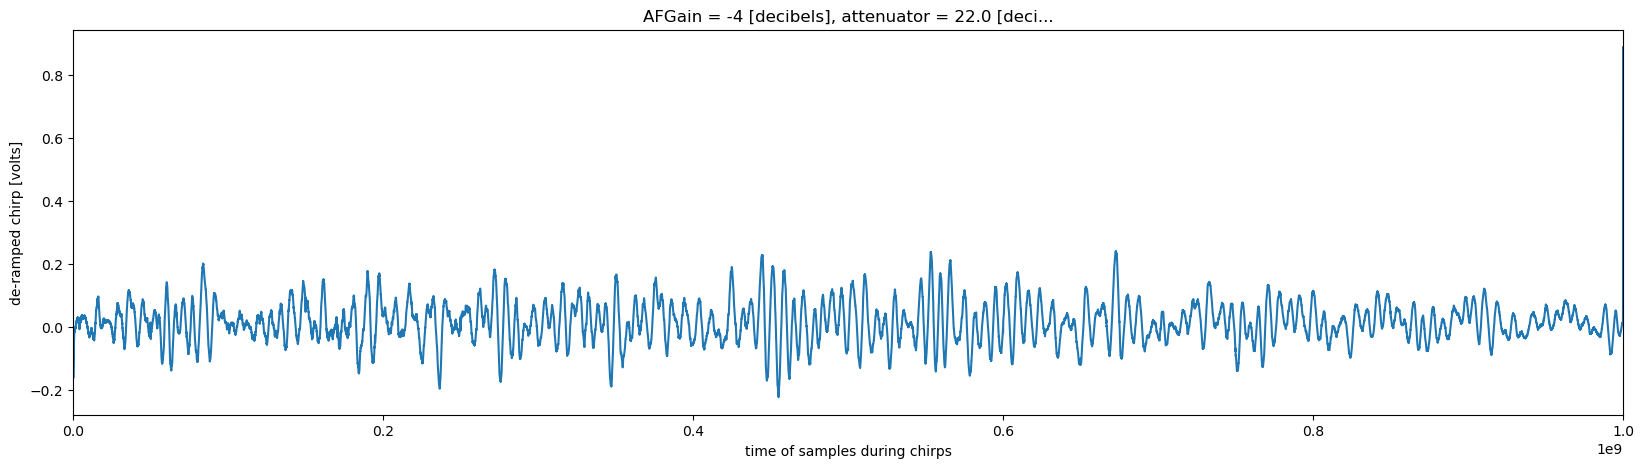

In [2]:
data.chirp.isel(chirp_num = 50, time = 200).plot(figsize = (20,5), xlim = (0, 1e9));

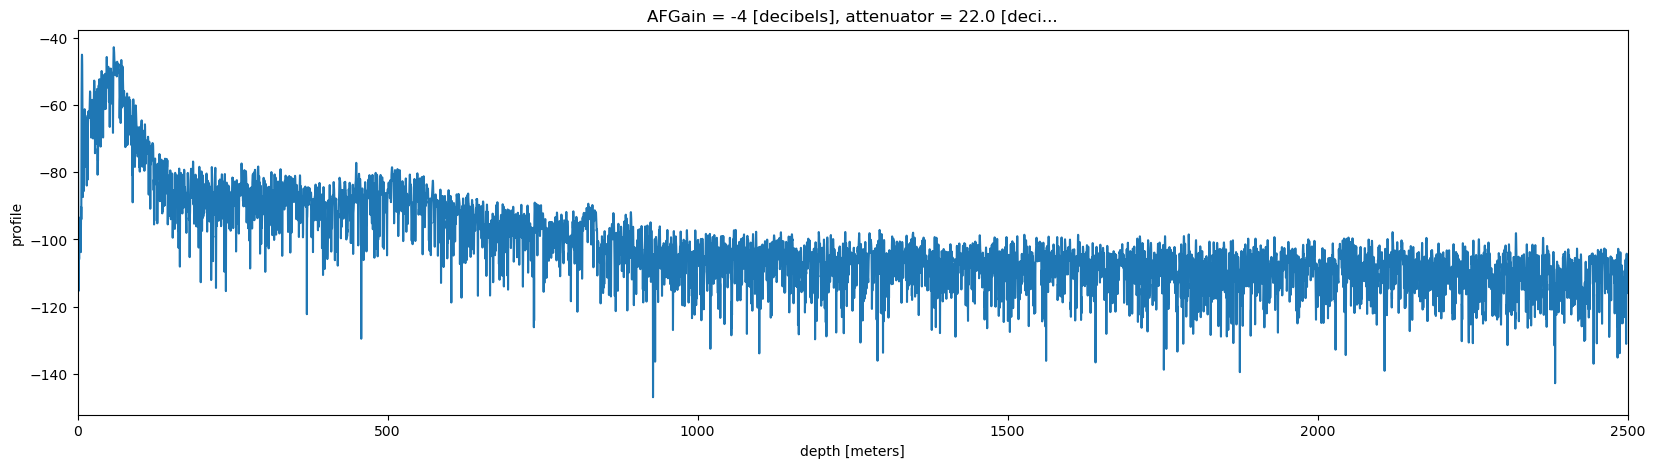

In [3]:
data.profile.dB().isel(chirp_num = 50, time = 200).plot(figsize = (20,5), xlim = (0, 2500));

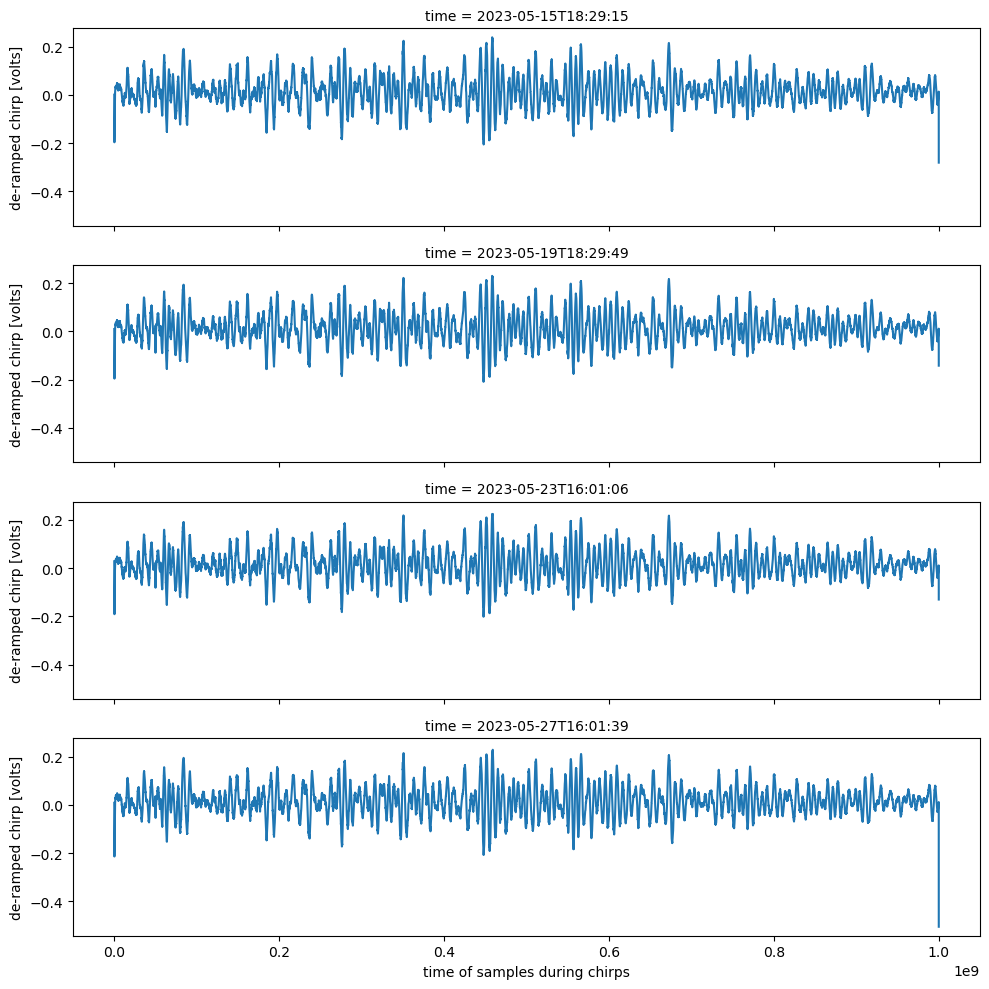

In [4]:
data.chirp.sel(chirp_num=0, time = slice('2023-05-15','2023-05-30', 4)).plot(row='time', figsize = (10, 10));

### Histograms 


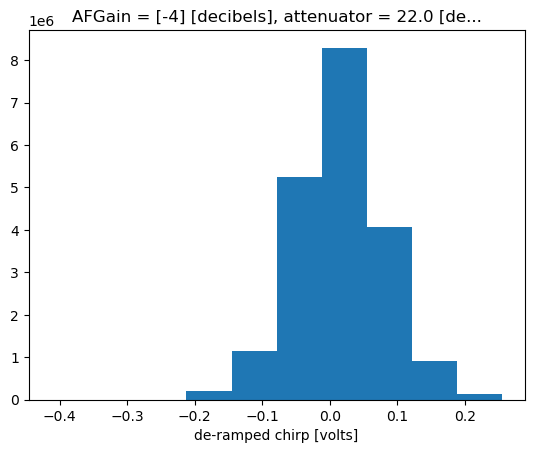

In [ ]:
data.chirp.isel(time = slice(20, 25)).plot.hist();   

```{note}
    Usually you would plot a larger subset of the data in a histogram, but `time = slice(20,25)` saves time downloading data in this guide. 
```

A consideration when designing a ApRES survey is avoiding 'clipping' If the returned signal is too high in amplitude multiple components inside the radar can behave in undesirable ways, leading to distortions in the signal or artificial cropping of the chirp at a maximum and minimum value. This is referred to as 'clipping'. Plotting a histogram of the chirp data is useful for choosing attenuator settings to avoid clipping. Usually this is done on the radar unit itself while connected to a laptop in the field, but it can also be useful in post-processing.  

### Time series of profiles

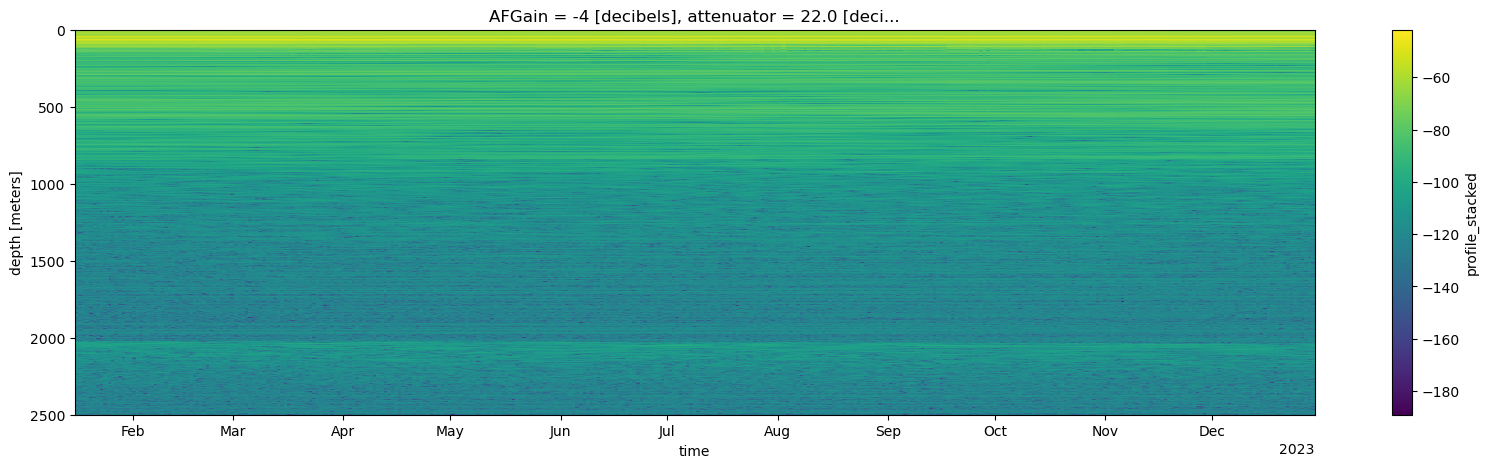

In [6]:
data.profile_stacked.dB().squeeze().plot(x='time', yincrease = False, figsize = (20,5));

### Time series of velocity/displacement/coherence/phase

In [2]:
d = data.profile_stacked.displacement_timeseries()

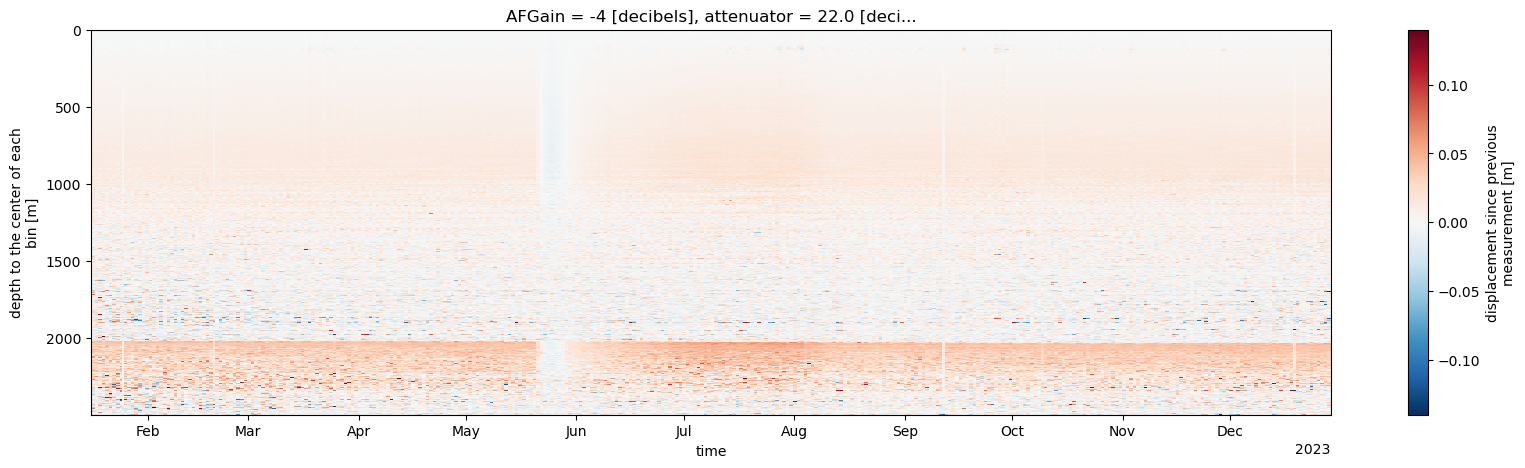

In [ ]:
variable_to_plot = ['coherence','phase','phase_uncertainty','velocity', 'displacement', 'disp_uncertainty']

d[variable_to_plot[4]].plot(figsize = (20,5), y='bin_depth', x='time', yincrease = False);

### Multiple velocity profiles

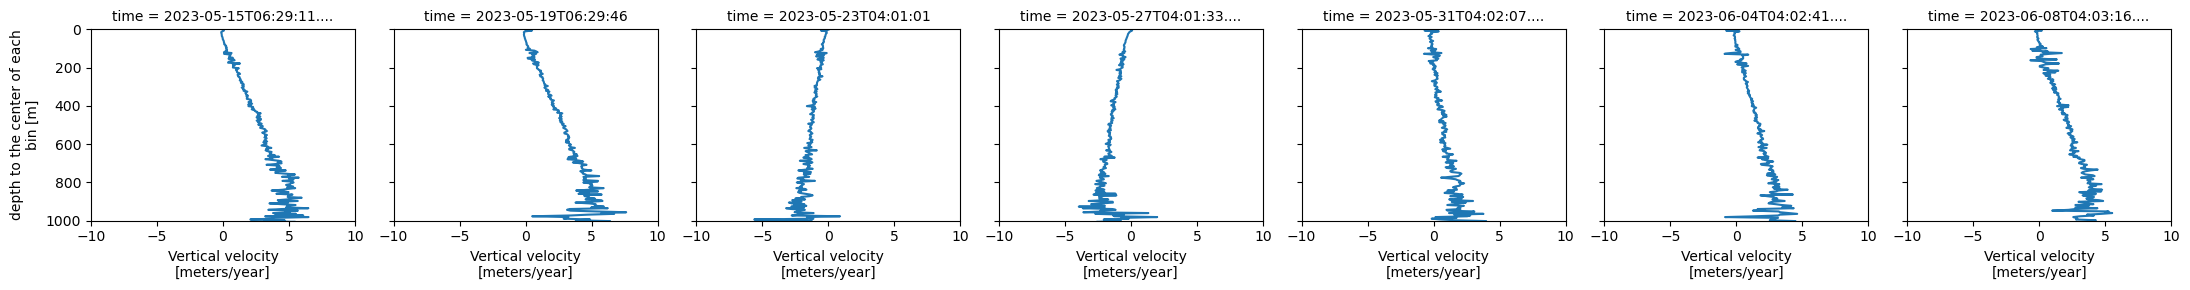

In [12]:
d.velocity.sel(time = slice('2023-05-15','2023-06-10', 4)).plot(col = 'time', y = 'bin_depth', yincrease = False, ylim = (1000, 0), xlim = (-10, 10));

### Interactive plot with mutliple profiles

In [4]:
import hvplot.xarray
import numpy as np

sliced = d.squeeze().sel(time = slice('2023-05-15','2023-06-10'))

sliced.velocity.hvplot(y = "bin_depth", groupby = "time", height = 400, width = 400,  xlim = (-10, 10), flip_yaxis=True)\
    + np.abs(sliced.coherence).hvplot(y = "bin_depth", groupby = "time", height = 400, width = 400,  xlim = (0.5, 1.1), flip_yaxis=True)

BokehModel(combine_events=True, render_bundle={'docs_json': {'8d85c025-dd6f-49fb-8d78-311e01c65e2e': {'version…

### Time series of strain rate

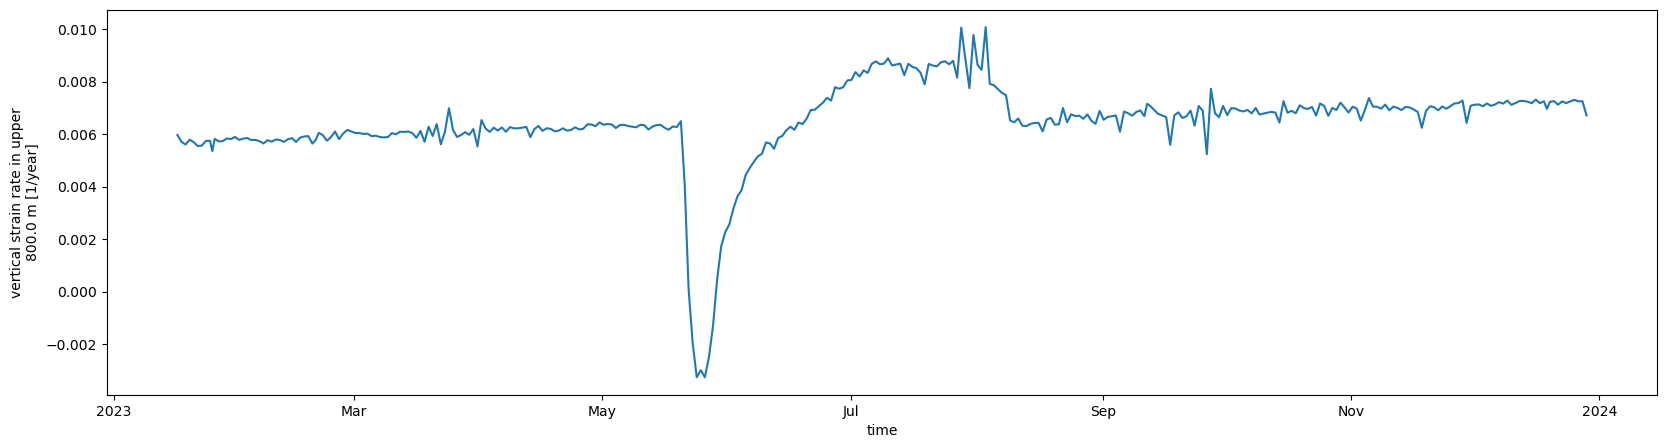

In [17]:
d.strain_rate.plot(figsize = (20,5));

## More complex plotting

### Progressive stacking

Create an xarray with many stacked profiles, each one created by averaging a different number of profiles.

In [29]:
da_list=[]
for n in data.chirp_num.values:
    da_list.append(data.isel(time=0, attenuator_setting_pair=0, chirp_num = slice(0,n)).profile.mean(dim='chirp_num').dB())

In [35]:
import xarray as xr
number_of_profile_stacked = xr.DataArray(np.arange(0, len(data.chirp_num)), dims='number_of_profile_stacked', name='number_of_profile_stacked')
da = xr.concat(da_list, dim = number_of_profile_stacked).rename('profile')

We can take a look at the effect of stacking on the noise floor by plotting out multiple profiles from the xarray we created above, each corresponding to a different number of profiles stacked together. 

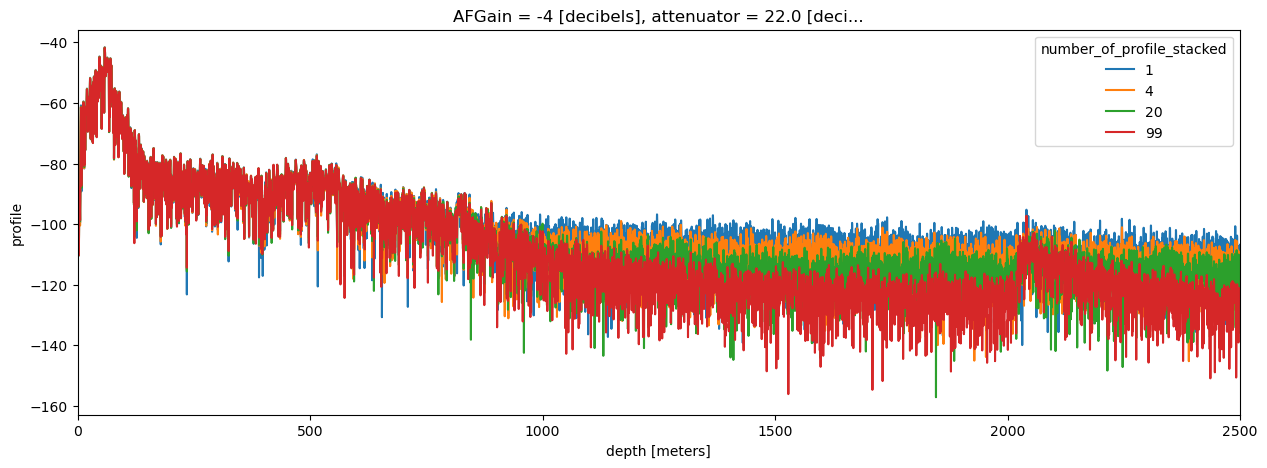

In [37]:
da.isel(number_of_profile_stacked =[1, 4, 20, 99]).plot(xlim = (0, 2500), hue = 'number_of_profile_stacked', figsize = (15, 5));


### Changing parameters and plotting results

`xarray_grid_search.grid_search` is a function currently stored in a github gist that provides a useful way of changing parameters and storing the result in an xarray dataset. 

/Users/jkingslake/Documents/science/ApRES/xapres/docs/src/xarray_grid_search.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/3 [00:00<?, ?it/s]

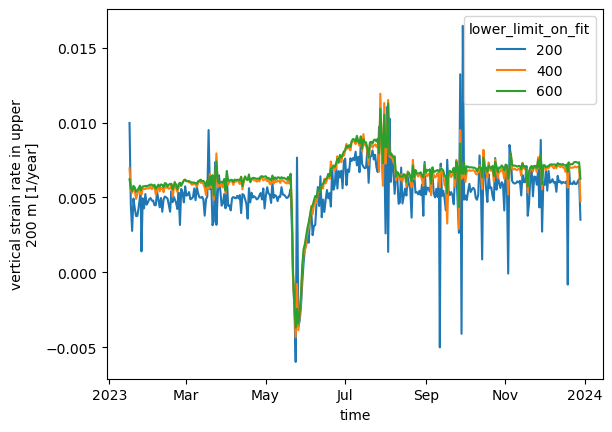

In [ ]:
!getgist jkingslake xarray_grid_search.py
import xarray_grid_search as xgs
varying_lower_fit_limit = xgs.gridSearch(data.profile_stacked.displacement_timeseries, lower_limit_on_fit=[200, 400, 600])
varying_lower_fit_limit.strain_rate.plot(hue='lower_limit_on_fit');

Unfortunately, `xarray_grid_search.grid_search` does not currently work well when you change parameters that result in changes to the length of the results in any dimension. You can still use the function, but it increases the volume of the data and introduces `nan`s that need to be dealt with before plotting. 

To deal with the common situation when you want to change a parameter that effects the length of the data, you can either apply `xarray_grid_search.grid_search` and interpolate the result to remove the `nan`s (this works, but is inefficient and may be slow for large datasets), or you can do things a bit more manually. 

Here's an example where we interpolate over the `nan`s. 

In [14]:
varying_bin_size = xgs.gridSearch(data.profile_stacked.displacement_timeseries, bin_size=[10, 20, 40, 50])
varying_bin_size

  0%|          | 0/4 [00:00<?, ?it/s]

/Users/jkingslake/miniconda3/envs/jupyter-book-env/lib/python3.13/site-packages/dask/array/core.py:4996: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/Users/jkingslake/miniconda3/envs/jupyter-book-env/lib/python3.13/site-packages/dask/array/core.py:4996: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/Users/jkingslake/miniconda3/envs/jupyter-book-env/lib/python3.13/site-packages/dask/array/core.py:4996: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/Users/jkingslake/miniconda3/envs/jupyter-book-env/lib/python3.13/site-packages/dask/array/core.py:4996: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/Users/jkingslake/miniconda3/envs/jupyter-book-env/lib/python3.13/site-packages/dask/array/core.py:4996: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/Users/jkingslake/miniconda3/envs/jupyter-boo

<xarray.Dataset> Size: 712MB
Dimensions:            (bin_size: 4, shot_number: 2, time: 350,
                        attenuator_setting_pair: 1, profile_range: 11889,
                        bin_depth: 2279)
Coordinates:
  * bin_size           (bin_size) int64 32B 10 20 40 50
  * profile_range      (profile_range) float64 95kB 0.0 0.2103 ... 2.5e+03
  * time               (time) datetime64[ns] 3kB 2023-01-16T12:51:57.500000 ....
  * shot_number        (shot_number) int64 16B 1 2
  * bin_depth          (bin_depth) float64 18kB 0.9463 1.998 ... 2.497e+03
    AFGain             (attenuator_setting_pair) int64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    attenuator         (attenuator_setting_pair) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    burst_number       (shot_number, time) int64 6kB dask.array<chunksize=(1, 350), meta=np.ndarray>
    filename           (shot_number, time) <U90 252kB dask.array<chunksize=(1, 350), meta=np.ndarray>
    orientation        (time) <U7 10kB 'unknown' 'unknown' ... 'unknown'
    profile_time       (shot_number, time) datetime64[ns] 6kB 2023-01-16T00:5...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    profile_stacked    (shot_number, time, attenuator_setting_pair, profile_range, bin_size) complex128 533MB dask.array<chunksize=(1, 21, 1, 11889, 1), meta=np.ndarray>
    coherence          (time, attenuator_setting_pair, bin_depth, bin_size) complex128 51MB dask.array<chunksize=(21, 1, 237, 1), meta=np.ndarray>
    phase              (time, attenuator_setting_pair, bin_depth, bin_size) float64 26MB dask.array<chunksize=(21, 1, 237, 1), meta=np.ndarray>
    phase_uncertainty  (time, attenuator_setting_pair, bin_depth, bin_size) float64 26MB dask.array<chunksize=(21, 1, 237, 1), meta=np.ndarray>
    displacement       (time, attenuator_setting_pair, bin_depth, bin_size) float64 26MB dask.array<chunksize=(21, 1, 237, 1), meta=np.ndarray>
    disp_uncertainty   (time, attenuator_setting_pair, bin_depth, bin_size) float64 26MB dask.array<chunksize=(21, 1, 237, 1), meta=np.ndarray>
    velocity           (time, attenuator_setting_pair, bin_depth, bin_size) float64 26MB dask.array<chunksize=(21, 1, 237, 1), meta=np.ndarray>
    strain_rate        (time, bin_size) float64 11kB dask.array<chunksize=(21, 1), meta=np.ndarray>
    surface_intercept  (time, bin_size) float64 11kB dask.array<chunksize=(21, 1), meta=np.ndarray>
    r_squared          (time, bin_size) float64 11kB dask.array<chunksize=(21, 1), meta=np.ndarray>
Attributes:
    bin_size:     10
    description:  Time series of profiles of coherence, phase, displacement, ...
    processing:   Created by the displacement_timeseries function in xapres u...
    offset:       1

Plotting variables that only have dimensions that are not the dimensions that changed in length is straightforward:

In [ ]:
varying_bin_size.strain_rate.hvplot( x = 'time')

BokehModel(combine_events=True, render_bundle={'docs_json': {'ffdd0924-3345-4f1a-a9f2-c125a51fb287': {'version…

However, to plot any of the 2D arrays we need to interpolate over the `nan`s that the varying dimension length introduces using `interpolate_na`. To do this we must first rechunk to have only one chunk in the `bin_depth` dimension:

In [ ]:
varying_bin_size_interpolated = varying_bin_size.chunk(dict(bin_depth=-1)).interpolate_na(dim='bin_depth')
varying_bin_size_interpolated.sel(time = slice('2023-05-15','2023-06-10') ).velocity.squeeze().hvplot(x='time', y = 'bin_depth')

BokehModel(combine_events=True, render_bundle={'docs_json': {'80a616d4-420d-4ecf-a764-5e2a24248a6b': {'version…

The more manual option avoids creating and interpolating over many `nan`s, so might be quicker in most cases.

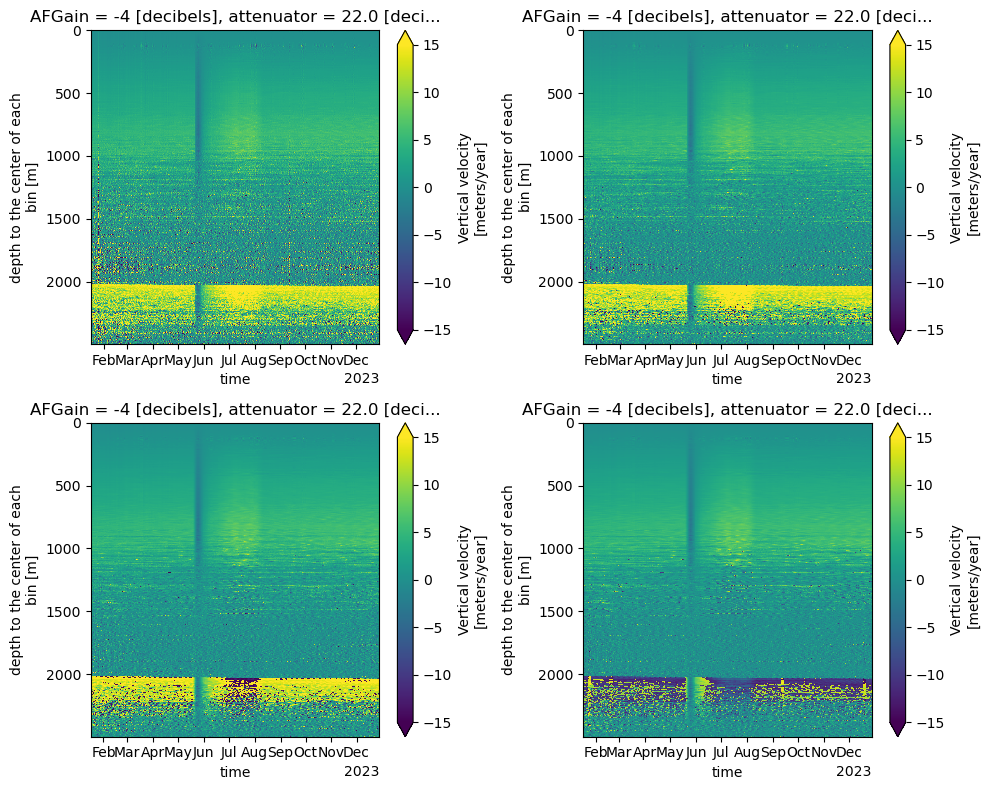

In [19]:
import matplotlib.pyplot as plt
fig, ax = fig, axs = plt.subplots(2, 2, figsize=(10, 8))

data.profile_stacked.displacement_timeseries(lower_limit_on_fit=800, offset = 1).velocity.plot(ax = ax[0,0], x='time', yincrease = False, vmin=-15, vmax = 15)
data.profile_stacked.displacement_timeseries(lower_limit_on_fit=800, offset = 2).velocity.plot(ax = ax[0,1], x='time', yincrease = False, vmin=-15, vmax = 15)
data.profile_stacked.displacement_timeseries(lower_limit_on_fit=800, offset = 3).velocity.plot(ax = ax[1,0], x='time', yincrease = False, vmin=-15, vmax = 15)
data.profile_stacked.displacement_timeseries(lower_limit_on_fit=800, offset = 4).velocity.plot(ax = ax[1,1], x='time', yincrease = False, vmin=-15, vmax = 15)
plt.tight_layout()

## Summary
- This page provides various ideas for exploratory plotting of ApRES data once it has been loaded into an xarray dataset.
- xarray's plotting tools make simple plots quick to make. 
- hvplot is another package that creates interactive plots that are useful for exploring multi-dimensional datasets. 
- `xarray_grid_search.grid_search` provides a way to change parameters and store the results, however it does not work well when the length of the data changes. 